**Name:** <span style="color:red">Jan Izquierdo</span>

# SYSTEMS AND NETWORK BIOLOGY - PRACTICAL 2 (PART 1)
# Robustness of gene regulatory networks

---

To submit your report, answer the questions below and save the *notebook* clicking on `File > Download as > iPython Notebook` in the menu at the top of the page. **Rename the notebook file** to ''`practicalN_name1_name2.ipynb`'', where `N` is the number of the practical, and `name1` and `name2` are the first surnames of the two team members (only one name if the report is sent individually). Finally, **submit the resulting file through the *Aul@-ESCI***.

Remember to label the axes in all the plots.

*IMPORTANT REMINDER: Before the final submission, remember to **reset the kernel** and re-run the whole notebook again to check that it works.*

---

In this session we will study two publicly available biological networks. We will assess their robustness to attacks. To that end we will use the Python package `NetworkX`.

# 0. NetworkX instructions

These are the main `NetworkX` instructions that you will need to use in this practical:

*   `<graph>.to_undirected()` returns an undirected graph representation of the `<graph>` directed graph object. This allows to use some of the Networkx methods that only work with undirected graphs.

*   `<graph_copy> = <graph>.copy()` returns a copy of the `<graph>` graph object. 

*   `<graph>.number_of_nodes()` returns the number of nodes of the `<graph>` object.

*   `<graph>.number_of_edges()` returns the number of edges of the `<graph>` object.

*   `<graph>.nodes()` returns a list with all the nodes in `<graph>`.

*   `networkx.adjacency_matrix(<graph>)` creates the adjacency matrix of a network. The matrix is produced in the `SciPy` sparse format. You should use the `todense` method of this data type to generate a `numpy` matrix.

*   `networkx.number_connected_components(<graph>)` returns the number of connected components of the undirected graph `<graph>`.

*   `networkx.connected_component_subgraphs(<graph>)` returns a list of the connected components in the undirected graph `<graph>`. The components are ordered from the largest to the smallest. ***Use the function below if you receive an error here***
*   `<graph>.subgraph(c) for c in nx.connected_components(<graph>)` does the same as the function directly above. Use this if you receive an error when trying to use the function above.

*   `<graph>.remove_node(<node>)` removes the node with name `<node>` from the `<graph>` graph.
*   `networkx.draw_networkx` draws the network. It is convenient to use the `pos` argument with the `spring_layout` function of NetworkX to position the nodes such that the network is not too tangled.

First, load all necessary Python modules (including NetworkX).

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Network analysis

There is a large number of databases of cellular regulatory networks (involving metabolic reactions, protein-protein interactions, gene regulation, ...). In this practical session we will work with transcription factor networks, which can usually be treated as directed simple graphs. We will the **RegulonDB** database, which contains most known gene regulatory interactions in _Escherichia coli_. To download the database, access the [RegulonDB website](http://regulondb.ccg.unam.mx/), then click **Downloads** and then **Experimental Datasets**. Finally, download the file labeled **TF - gene interactions**, and place it in the folder where you will be working.

To load the network you can use the following function:

In [2]:
def load_network(file_path):
    file_object = open(file_path, mode="r")       # open the file in reading (r) mode
    network_object = nx.DiGraph()                 # Create a directed graph object
    
    for line in file_object:                      # For each line in the file
        if line.startswith("#") or line == "\n":  # skip the line if it starts with #, or
                                                  # if it's empty ()
            continue
        line = line.lower().split()               # remove uppercase letters and
                                                  # split the line into words
        network_object.add_edge(line[0], line[1]) # add an edge going from the node specified
                                                  # in the first column to the
                                                  # one specified in the second column
    return network_object

Load the database into a graph object and calculate the number of genes (nodes), interactions (edges) and the mean degree.

In [3]:
nw=load_network("network_tf_gene.txt")
nodes=nw.number_of_nodes()
edges=nw.number_of_edges()
mdegree=(2*edges)/nodes

print(f"Genes: {nodes}\nInteractions: {edges}\nMean degree: {mdegree}")

Genes: 1909
Interactions: 4439
Mean degree: 4.650602409638554


---

<span style="color:red">Comment your result here</span>

---

How many _connected components_ (a set of vertices in a graph that are linked to each other by
paths) does the network have? Select the largest component of the network (save it to a new
graph) and repeat the calculations of number of nodes, number of edges and mean degree. Draw this new subgraph.

Nodes: 1802
Edges: 4328
Mean degree: 4.803551609322975


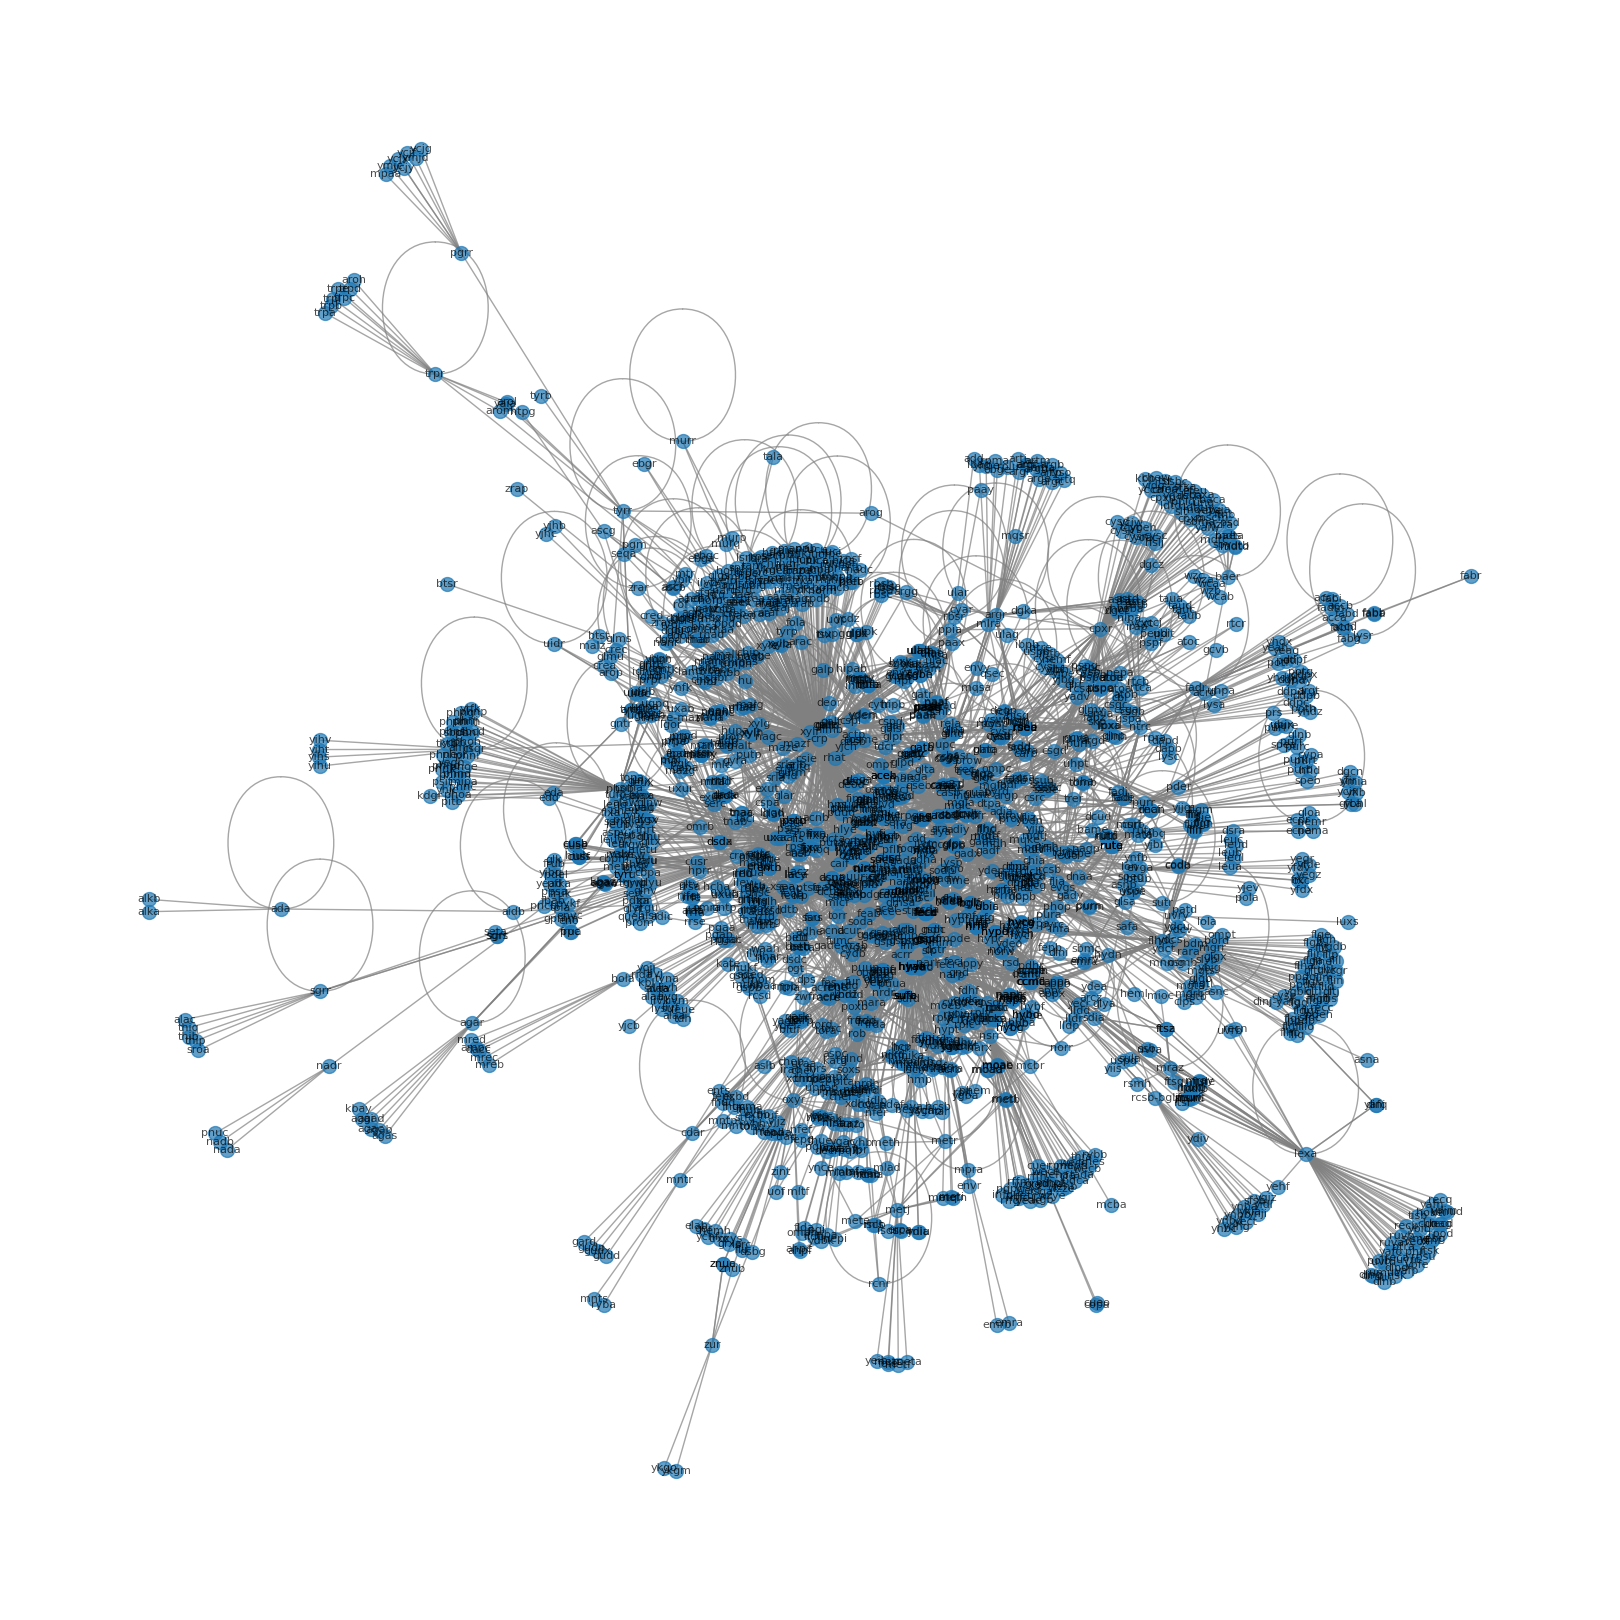

In [14]:
u_nw=nw.to_undirected()
con_comp=nx.number_connected_components(u_nw)
m_component=max(nx.connected_components(u_nw))
m_nw=nw.subgraph(m_component).to_undirected().copy()
safe_m_nw=m_nw.copy() #To use on a latter exercise

m_nodes=m_nw.number_of_nodes()
m_edges=m_nw.number_of_edges()
m_mdegree=(2*m_edges)/m_nodes

print(f"Nodes: {m_nodes}\nEdges: {m_edges}\nMean degree: {m_mdegree}")

plt.figure(figsize=(16, 16)) 
nx.draw(m_nw, node_size=100, font_size=8, alpha=0.7, with_labels=True, edge_color="gray")

---

<span style="color:red">Comment your result here</span>

---

Next, create the adjacency matrix of the network, and use it to compute the degrees of all nodes and the average degree of the network. Print the average degree and plot the degree distribution of the network **(do NOT use specially dedicated functions of NetworkX for those tasks)**.

The average degree of the network is: 4.650602409638554


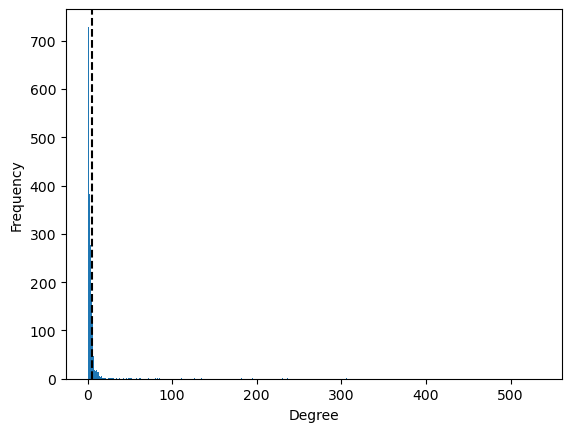

In [9]:
am_nw=nx.adjacency_matrix(nw)

degrees = np.sum(am_nw, axis=1) + np.sum(am_nw, axis=0) #These are numpy functions, not dedicated NetworkX functions

average_degree = np.mean(degrees)
print("The average degree of the network is:",average_degree)

plt.hist(degrees, bins=range(min(degrees), max(degrees+1)))
plt.axvline(average_degree, color='black', linestyle='dashed', linewidth=1.5)
plt.xlabel(f"Degree")
plt.ylabel(f"Frequency")
plt.show()


---

<span style="color:red">The majority of the nodes have degree 0, the rest also tend to have a low degree</span>

---

# 2. Robustness to failures

Different classes of networks react in different ways when some of their nodes disappear. Here we will study the robustness to random failures **using only the largest connected component of the RegulonDB network**. To do so, copy the largest connected component of the network into a new graph. Next remove iteratively 20 arbitrary (i.e. randomly chosen) nodes from this graph and check if its connectivity has changed: does it remain as a single connected component or does the failure break it apart into multiple sub-graphs?

**Note**: to select a random node use the function `randint` from the module `numpy.random`.

In [58]:
m_nw=safe_m_nw.copy()
np.random.seed(1)

def rm_20(i): #a for loop  (for _ in range(20): ) would be a better option
    if i==0:
        return

    nodelist = list(m_nw.nodes)
    n = np.random.randint(0, len(nodelist)) #select a node from the current total of nodes
    m_nw.remove_node(nodelist[n])

    return rm_20(i-1)

rm_20(20)



In [59]:
print(f"The numbers of nodes should be {m_nodes-20}, and is: {m_nw.number_of_nodes()}" )
print("The graph is connected:", nx.is_connected(m_nw))


The numbers of nodes should be 1782, and is: 1782
The graph is connected: True


---

<span style="color:red">The graph remains connected even though we removed 20 nodes, most nodes have a very low degree, therefore its more possible that the chosen nodes's degrees are low. That a node has a low degree means that it has less connections, so more possible that that node is not essential, that an alternative connection is present in the graph.</span>

---

# 3. Sensitivity to attacks

We now study the effect of directed attacks, namely removal of the most important nodes of the network, and see how they affect its connectivity. Although there is a variety of ways to measure the importance of a node, for the sake of simplicity we will restrict ourselves to using the degree.

Using the `sorted` function in Python, list the 10 nodes with highest degree.

In [47]:


def top_degree_finder(network):
    deg_dict=dict(network.degree()) #get "node": degree dictionary
    deg_as_key = dict(zip(deg_dict.values(), deg_dict.keys())) #make degrees keys and nodes values
    high_degrees=sorted(deg_as_key.keys(), reverse=True)[:10] #get 10 highest degrees (dict keys)

    return [deg_as_key, high_degrees] #print dictionary and 10 highest keys

[deg_as_key, high_degrees]=top_degree_finder(nw)
c=1
for deg in high_degrees: #iterate over the highest degrees
    print("The node",deg_as_key[deg],"is ranked number",c) #print the value of the degrees
    c+=1



The node crp is ranked number 1
The node fnr is ranked number 2
The node fis is ranked number 3
The node ihf is ranked number 4
The node h-ns is ranked number 5
The node arca is ranked number 6
The node fur is ranked number 7
The node narl is ranked number 8
The node lrp is ranked number 9
The node nsrr is ranked number 10


Generate a new copy of the largest component of the network as you did above. Remove iteratively the 10 nodes with highest degree of the network and check how the connectivity changes.

In [51]:
m_nw=safe_m_nw.copy() #copy the largest component

[deg_as_key, high_degrees]=top_degree_finder(m_nw)

for deg in high_degrees: #iterate over the highest degrees
    m_nw.remove_node(deg_as_key[deg]) #remove the nodes

print(f"The numbers of nodes should be {m_nodes-10}, and is: {m_nw.number_of_nodes()}" )
print("The graph is connected:", nx.is_connected(m_nw))


The numbers of nodes should be 1792, and is: 1792
The graph is connected: False


---

<span style="color:red">When we remove the nodes of highest connections(degree) the connectivity does break. This may be because before we were breaking nodes that had alternative connections, but when removing an important node its more possible than one of the connections presents no alternative, and the connectivity breaks.</span>

---